## Simulações de Monte Carlo do Modelo de Ising

**Nome:** Antônio Caetano Neves Neto

**Matrícula:** 2022043698

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from numba import jit


np.random.seed(82)

sns.set(style="darkgrid")
sns.set_palette("muted")

### Funções auxiliares

In [9]:
@jit(nopython=True)
def neighbors(N):
  L=int(np.sqrt(N))
  viz = np.zeros((N,4),dtype=np.int16)

  for k in range(N):
    viz[k,0]= k + 1

    if (k + 1) % L == 0:
      viz[k,0] = k+1-L

    viz[k,1] = k+L
    if k > (N-L-1):
      viz[k,1] = k+L-N
    viz[k,2] = k-1
    if (k % L == 0):
      viz[k,2] = k+L-1
    viz[k,3] = k-L
    if k < L:
      viz[k,3] = k+N-L

  return viz

In [10]:
@jit(nopython=True)
def expos(beta):
  ex = np.zeros(5,dtype=np.float32)
  ex[0]=np.exp(8.0*beta)
  ex[1]=np.exp(4.0*beta)
  ex[2]=1.0
  ex[3]=np.exp(-4.0*beta)
  ex[4]=np.exp(-8.0*beta)
  return ex

In [11]:
@jit(nopython=True)
def energia(s,viz):
  N = len(s)
  ener = 0

  for i in range(N):
    h = s[viz[i,0]] + s[viz[i,1]]
    ener -= s[i]*h
  return ener

In [12]:
@jit(nopython=True)
def metropolis_step(s, viz, ex):
  N = len(s)
  for _ in range(N):
    i = np.random.randint(0, N)
    h = s[viz[i,0]] + s[viz[i,1]] + s[viz[i,2]] + s[viz[i,3]]
    delta_E = 2 * s[i] * h
    idx = int(s[i]*h*0.5 + 2)
    P = ex[idx]
    if np.random.rand() < P:
      s[i] = -s[i]
  return s

### Atividade 1

In [13]:
@jit(nopython=True)
def termalizacao(N, beta, n_steps):
    s = np.random.randint(0, 2, N) * 2 - 1
    viz = neighbors(N)
    ex = expos(beta)

    energy = np.zeros(n_steps, dtype=np.int32)
    magnetization = np.zeros(n_steps, dtype=np.int32)

    for i in range(n_steps):
        metropolis_step(s, viz, ex)
        energy[i] = energia(s, viz)
        magnetization[i] = np.sum(s)

    return energy, magnetization

24it [03:20,  8.36s/it]


[]

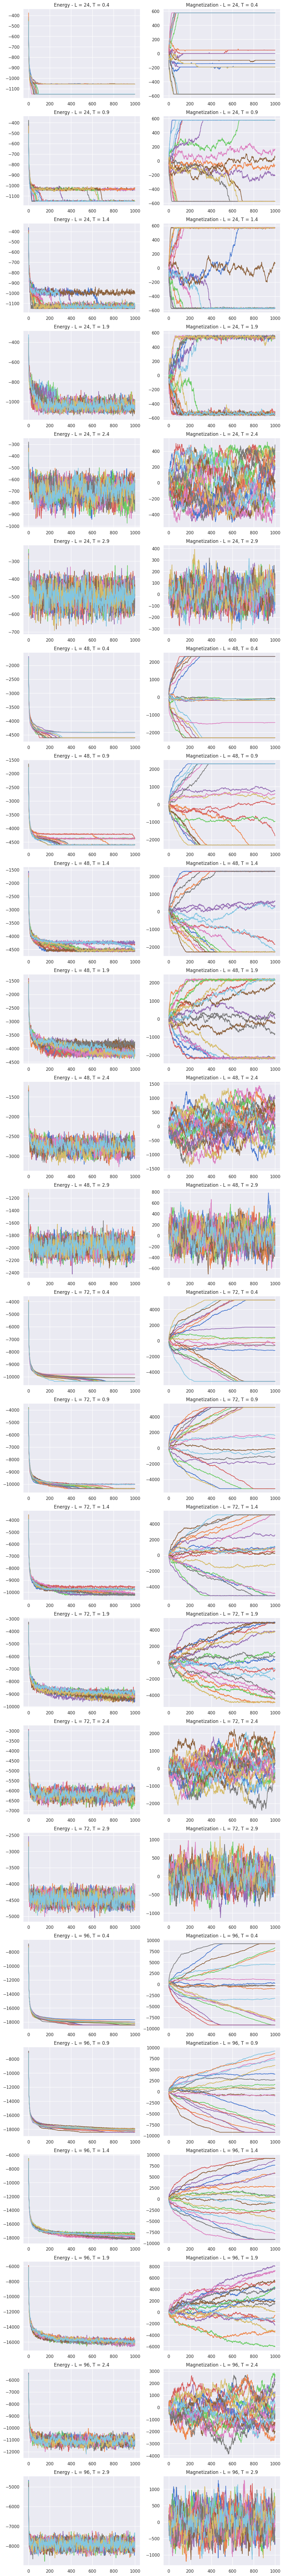

In [14]:
n_steps = 1000

L_values = [24, 48, 72, 96]
temperature_values = [0.4, 0.9, 1.4, 1.9, 2.4, 2.9]

combinations = [(L, temperature) for L in L_values for temperature in temperature_values]

fig, axis = plt.subplots(len(combinations), 2, figsize=(12, 5*len(combinations)))

for it, params in tqdm(enumerate(combinations)):
  L, temperature = params
  for _ in range(20):
    energy, magnetization = termalizacao(L*L, 1 / temperature, n_steps)

    axis[it, 0].plot(energy)
    axis[it, 1].plot(magnetization)

  axis[it, 0].set_title(f"Energy - L = {L}, T = {temperature}")
  axis[it, 1].set_title(f"Magnetization - L = {L}, T = {temperature}")

plt.plot()

Nos gráficos, a energia do sistema em uma simulação de Metropolis diminui rapidamente no início e se estabiliza em valores negativos, especialmente para temperaturas mais baixas, onde o sistema tende a se organizar mais. À medida que a temperatura aumenta, as flutuações de energia se intensificam, indicando uma menor estabilidade e ordem no sistema. Em altas temperaturas, a energia não se estabiliza, mostrando um comportamento caótico esperado em condições de maior agitação térmica.

Em detrimento, o aumento do número de partículas no sistema faz com que o efeito de aumento da agitação térmica seja diminuído, possuindo um comportamento parecido independente do estado inicial do sistema, mas com um decrescimento devagar da energia do sistema em relação a valores de L mais baixos.

Além disso, é notado que para L altos, é necessário mais passos de iteração para chegar em um ponto de estabilidade térmica, especialmente analisando a magnetização do sistema, na qual para L baixos e temperaturas baixas, com poucos passos o sistema converge para um dos extremos de magnetização, mas quando ambas as variáveis aumenta, o número de passos de convergência aumenta e até mesmo o sistema pode tornar caótico, nunca convergindo para um dos extremos de magnetização.

### Atividade 2

In [15]:
@jit(nopython=True)
def termalizacao_for_mcs(N, beta, n_term, n_mcs):
  np.random.seed(1)
  s = np.random.randint(0, 2, N) * 2 - 1
  viz = neighbors(N)
  ex = expos(beta)

  # energy = []
  for _ in range(n_term):
      metropolis_step(s, viz, ex)
      # energy.append(energia(s, viz))

  energy = []
  magnetization = []
  for it in range(n_mcs):
    metropolis_step(s, viz, ex)
    magnetization.append(np.abs(np.sum(s)))
    energy.append(energia(s, viz))

  return np.array(energy), np.array(magnetization)

#### 1. Quais critérios você utilizou para escolher os valores dos parâmetros descritos acima?

Para ter um sistema que tenha um valor estacionário mais baixo, para que o cálculo das medidas termodinâmicas possa ser ideal, foi escolhido um L médio dos testados, e uma temperatura média dentre as amostradas na atividade 1. Logo, 1.4, para que não tenha uma variação abrupta entre estados iniciais, mas também não seja todas parecidas. Além da definição de L = 48.

Para os passos de termalização e de cálculos das medidas termodinâmicas, foi decidido eles terem o mesmo tamanho amostral, na qual seja possível verificar graficamente uma periodicidade no espaço de cálculo termodinâmico. Logo, o steps decidido foi de 10.000. É importante salientar que foi orientado por meio de resposta a dúvida que o número ideal é 100 * L², entretanto, isso seria devidamente custoso ao sistema, sendo por volta de 240.000 passos de convergência.

Por fim, outro critério foi a semelhança entre os resultados para diferentes estados iniciais. A partir dos plots, é visualizado que não há amostras que se divergem da tendência central de periodicidade, tanto em energia quanto em magnetização.

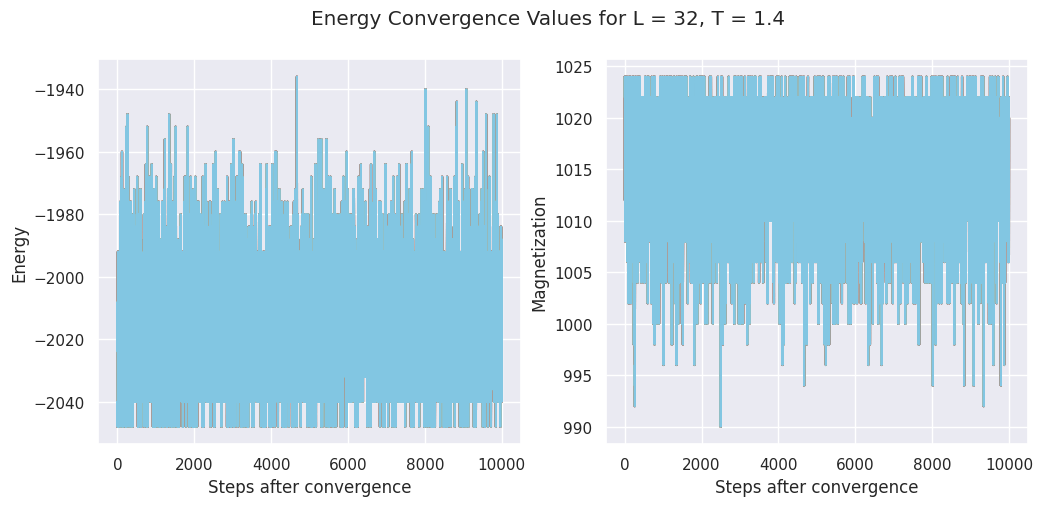

In [16]:
L = 32
temperature = 1.4
n_steps = 10000

fig, axis = plt.subplots(1, 2, figsize=(12, 5))

for it in range(10):
  energy, magnetization = termalizacao_for_mcs(L*L, 1 / temperature, n_steps, n_steps)

  axis[0].plot(energy)
  axis[1].plot(magnetization)

plt.suptitle(f"Energy Convergence Values for L = {L}, T = {temperature}")
axis[0].set_xlabel("Steps after convergence")
axis[0].set_ylabel("Energy")

axis[1].set_xlabel("Steps after convergence")
axis[1].set_ylabel("Magnetization")
plt.show()

#### 2. Descreva o comportamento observado para as principais grandezas termodinâmicas – Energia por spin, Magnetização por spin, calor específico e susceptibilidade magnética – em função da temperatura. Ou seja, ao variar a temperatura, o que acontece com o valor destas grandezas? Quais são os limites para baixas e altas temperaturas? Há algum pico ou vale? O comportamento está em acordo com o que você esperava?

In [17]:
def box_method(values, N):
  boxes = np.array_split(values, N)

  averages = [np.mean(box) for box in boxes]
  final_average = np.mean(averages)

  return final_average, np.sqrt(np.sum((averages - final_average)**2) / (len(averages)*(len(averages)-1)))

In [18]:
def specific_heat_with_box_method(energy_values, N, temperature, n_spins):
  boxes = np.array_split(energy_values, N)

  averages = np.array([np.mean(box) for box in boxes])
  averages_square = np.array([np.mean(box**2) for box in boxes])

  heat_for_box = (averages_square - averages**2) / (n_spins * (temperature**2))

  return np.mean(heat_for_box), np.sqrt(np.sum((heat_for_box - np.mean(heat_for_box))**2) / (len(heat_for_box)*(len(heat_for_box)-1)))

In [19]:
def magnetic_susceptibility_with_box_method(magnetization_values, N, temperature, n_spins):
  boxes = np.array_split(magnetization_values, N)

  averages = np.array([np.mean(box) for box in boxes])
  averages_square = np.array([np.mean(box**2) for box in boxes])

  susceptibility_for_box = (averages_square - averages**2) / (n_spins*temperature)

  return np.mean(susceptibility_for_box), np.sqrt(np.sum((susceptibility_for_box - np.mean(susceptibility_for_box))**2) / (len(susceptibility_for_box)*(len(susceptibility_for_box)-1)))

100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


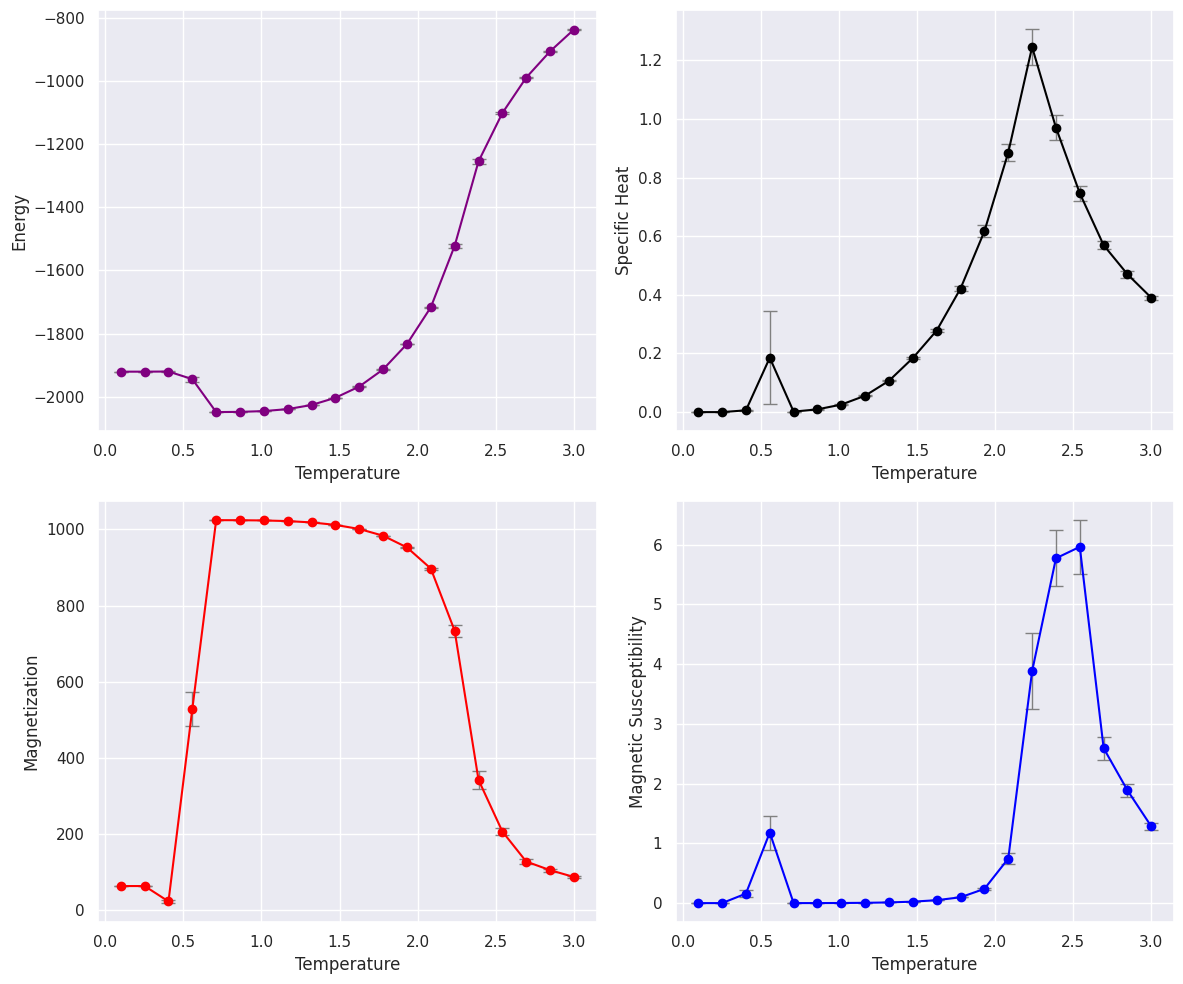

Energy and Magnetization vs. Temperature (L=32)


In [20]:
n_samples = 20
n_boxes = 50
temperature_range = np.linspace(0.1, 3, n_samples)

error_by_temperature = []
energy_averages_by_temperatue = []

magnetization_averages_by_temperatue = []
magnetization_error_by_temperatue = []

specific_heat_averages_by_temperatue = []
specific_heat_error_by_temperatue = []

magnetic_susceptibility_averages_by_temperatue = []
magnetic_susceptibility_error_by_temperatue = []

fig, axis = plt.subplots(2, 2, figsize=(12, 10))

for temperature in tqdm(temperature_range):
  energy, magnetization = termalizacao_for_mcs(L*L, 1/temperature, n_steps, n_steps)

  average_energy, error_energy = box_method(energy, n_boxes)
  average_magnetization, error_magnetization = box_method(magnetization, n_boxes)

  average_specific_heat, error_specific_heat = specific_heat_with_box_method(energy, n_boxes, temperature, L*L)
  average_magnetic_susceptibility, error_magnetic_susceptibility = magnetic_susceptibility_with_box_method(magnetization, n_boxes, temperature, L*L)

  error_by_temperature.append(error_energy)
  energy_averages_by_temperatue.append(average_energy)

  magnetization_averages_by_temperatue.append(average_magnetization)
  magnetization_error_by_temperatue.append(error_magnetization)

  specific_heat_averages_by_temperatue.append(average_specific_heat)
  specific_heat_error_by_temperatue.append(error_specific_heat)

  magnetic_susceptibility_averages_by_temperatue.append(average_magnetic_susceptibility)
  magnetic_susceptibility_error_by_temperatue.append(error_magnetic_susceptibility)

axis[0, 0].errorbar(temperature_range, energy_averages_by_temperatue, yerr=error_by_temperature, fmt='-o', color="purple", ecolor='gray', capsize=5, capthick=1, elinewidth=1)
axis[0, 0].set_xlabel("Temperature")
axis[0, 0].set_ylabel("Energy")

axis[1, 0].errorbar(temperature_range, magnetization_averages_by_temperatue, yerr=magnetization_error_by_temperatue, fmt='-o', color="red", ecolor='gray', capsize=5, capthick=1, elinewidth=1)
axis[1, 0].set_xlabel("Temperature")
axis[1, 0].set_ylabel("Magnetization")

axis[0, 1].errorbar(temperature_range, specific_heat_averages_by_temperatue, yerr=specific_heat_error_by_temperatue, color="black", fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1)
axis[0, 1].set_xlabel("Temperature")
axis[0, 1].set_ylabel("Specific Heat")

axis[1, 1].errorbar(temperature_range, magnetic_susceptibility_averages_by_temperatue, yerr=magnetic_susceptibility_error_by_temperatue, color="blue", fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1)
axis[1, 1].set_xlabel("Temperature")
axis[1, 1].set_ylabel("Magnetic Susceptibility")

plt.tight_layout()
plt.show()

print("Energy and Magnetization vs. Temperature (L=32)")

É possível notar que, conforme a temperatura aumenta, as medidas termodinâmicas calculadas pelas médias adquiridas pelo método variam de acordo. A energia tende a variar em sentido crescente, se aproximando a 0. Comportamento quase semelhante com o calor específico, que atinge um pico perto de 2.4, contudo, depois decai, indicando uma provável transição de fase do sistema.

Em relação a magnetização, é notado um comportamento variado entre 0 e 1 de temperatura, que depois vê a magnetização caindo para zero conforme a temperatura aumenta e a susceptibilidade magnética tendo o efeito oposto, mas bem caracterizada pelo pico de susceptibilidade perto de 2.4.

### 3. Ao variar o tamanho do sistema, como as curvas destas grandezas em função da temperatura se modifica? Há algum intervalo de temperaturas no qual as grandezas são independentes do tamanho do sistema? Em regiões onde há variação com o tamanho do sistema, como a grandeza é modificada quando 𝐿 aumenta?

100%|██████████| 30/30 [08:55<00:00, 17.85s/it]


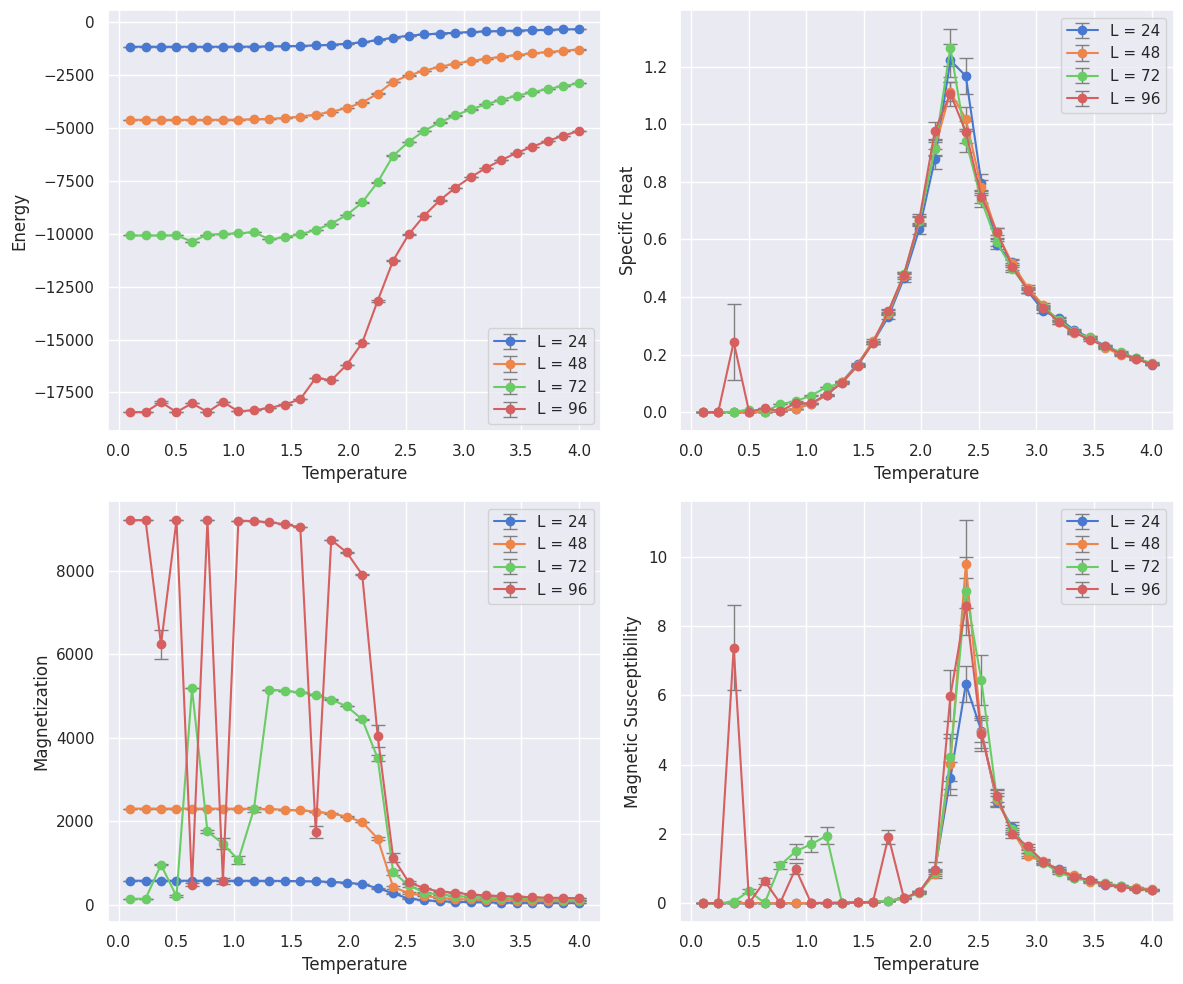

In [21]:
n_boxes = 50
n_samples = 30
temperature_range = np.linspace(0.1, 4, n_samples)

fig, axis = plt.subplots(2, 2, figsize=(12, 10))

for L in [24, 48, 72, 96]:
  error_by_temperature = []
  energy_averages_by_temperatue = []

  magnetization_averages_by_temperatue = []
  magnetization_error_by_temperatue = []

  specific_heat_averages_by_temperatue = []
  specific_heat_error_by_temperatue = []

  magnetic_susceptibility_averages_by_temperatue = []
  magnetic_susceptibility_error_by_temperatue = []

  for temperature in tqdm(temperature_range):
    energy, magnetization = termalizacao_for_mcs(L*L, 1/temperature, n_steps, n_steps)

    average_energy, error_energy = box_method(energy, n_boxes)
    average_magnetization, error_magnetization = box_method(magnetization, n_boxes)

    average_specific_heat, error_specific_heat = specific_heat_with_box_method(energy, n_boxes, temperature, L*L)
    average_magnetic_susceptibility, error_magnetic_susceptibility = magnetic_susceptibility_with_box_method(magnetization, n_boxes, temperature, L*L)

    error_by_temperature.append(error_energy)
    energy_averages_by_temperatue.append(average_energy)

    magnetization_averages_by_temperatue.append(average_magnetization)
    magnetization_error_by_temperatue.append(error_magnetization)

    specific_heat_averages_by_temperatue.append(average_specific_heat)
    specific_heat_error_by_temperatue.append(error_specific_heat)

    magnetic_susceptibility_averages_by_temperatue.append(average_magnetic_susceptibility)
    magnetic_susceptibility_error_by_temperatue.append(error_magnetic_susceptibility)

  axis[0, 0].errorbar(temperature_range, energy_averages_by_temperatue, yerr=error_by_temperature, fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1, label=f"L = {L}")
  axis[1, 0].errorbar(temperature_range, magnetization_averages_by_temperatue, yerr=magnetization_error_by_temperatue, fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1, label=f"L = {L}")
  axis[0, 1].errorbar(temperature_range, specific_heat_averages_by_temperatue, yerr=specific_heat_error_by_temperatue, fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1, label=f"L = {L}")
  axis[1, 1].errorbar(temperature_range, magnetic_susceptibility_averages_by_temperatue, yerr=magnetic_susceptibility_error_by_temperatue, fmt='-o', ecolor='gray', capsize=5, capthick=1, elinewidth=1, label=f"L = {L}")


axis[0, 0].set_xlabel("Temperature")
axis[0, 0].set_ylabel("Energy")
axis[0, 0].legend()

axis[1, 0].set_xlabel("Temperature")
axis[1, 0].set_ylabel("Magnetization")
axis[1, 0].legend()

axis[0, 1].set_xlabel("Temperature")
axis[0, 1].set_ylabel("Specific Heat")
axis[0, 1].legend()

axis[1, 1].set_xlabel("Temperature")
axis[1, 1].set_ylabel("Magnetic Susceptibility")
axis[1, 1].legend()

plt.tight_layout()
plt.show()

Ao observar as curvas de energia, calor específico, magnetização e susceptibilidade magnética em função da temperatura para diferentes tamanhos do sistema (L = 24, 48, 72 e 96), nota-se que o comportamento de cada grandeza muda conforme a temperatura e o tamanho do sistema. Em baixas temperaturas, as grandezas de susceptibilidade magnética e calor específico possuem pouca diferença em relação ao tamanho do sistema. Também, na região de transição de fase, que ocorre entre aproximadamente 2.0 e 2.5 na escala de temperatura, apresenta um comportamento de pico de valor de ambas as métricas, com sistemas maiores possuindo um pico mais agudo, mas não tanto.

Quando o tamanho do sistema (L) aumenta, as curvas das grandezas termodinâmicas tendem a mostrar comportamentos mais agudos ou intensificados nas proximidades da temperatura crítica. Para o calor específico e a susceptibilidade magnética, observa-se que os picos se tornam mais altos e definidos com o aumento de L, indicando uma maior sensibilidade à transição de fase. Esse comportamento é esperado em sistemas maiores, pois eles representam melhor o limite termodinâmico, onde a transição de fase se torna mais nítida. Já para temperaturas mais altas, as grandezas tendem a se estabilizar e mostram menos variação com o tamanho do sistema, sugerindo uma convergência para valores que independem de L nessa região.

Para os valores de energia, quanto maior o sistema, mais acentuado o valor de energia é, entretanto, conforme a temperatura aumenta, o valor tende a ficar perto de 0.

O mesmo comportamento é notado nos valores de magnetismo, nos quais com sistemas maiores possuem valores maior, mas conforme aproxima da transição de fase, o magnetismo tende a 0.

### 4. Como é o comportamento dos erros estatísticos à medida que a temperatura varia? Tem algum valor de temperatura em torno do qual os erros são maiores? Você enxerga algum motivo para isso? Os erros estatísticos dependem do tamanho do sistema? Como?

Primeiramente, o erro no gráfico é caracterizado pela linha intervalar cinza sob cada ponto.


Os erros estatísticos aumentam significativamente perto da temperatura crítica (entre 2.0 e 2.5), onde ocorrem grandes flutuações nas grandezas físicas devido à transição de fase do modelo de Ising. Esse aumento se intensifica em sistemas maiores (valores de L mais altos), pois as flutuações são amplificadas, gerando incertezas maiores nas medições. Fora da região crítica, em temperaturas muito altas ou baixas, os erros são menores e menos afetados pelo tamanho do sistema, pois as flutuações são reduzidas.

É importante dizer que com o aumento da temperatura, é notado uma tendência de manter os valores termodinâmicos em um certo valor, diminuindo assim os erros estatísticos associados.

### 5. Com base no comportamento encontrado, identifique possíveis fases do sistema, descrevendo as principais características das fases encontradas.

Com base no comportamento das grandezas termodinâmicas, podemos identificar duas fases distintas no sistema:

**Fase Ordenada (Temperaturas Baixas)**: Em temperaturas abaixo da temperatura crítica, o sistema está em uma fase magnetizada, onde os spins tendem a se alinhar, resultando em uma magnetização elevada. Nesta fase, a energia é mais baixa e as flutuações são pequenas, indicando um estado ordenado e estável. É notável que essa fase se divide em duas conforme é aumentado o valor de L, onde abaixo de 1.0 de temperatura, o sistema é mais ordenado que entre 1.0 e 2.0, fato percebível pela curva de magnetização e susceptibilidade magnética.

**Fase Desordenada (Temperaturas Altas)**: Em temperaturas acima da temperatura crítica, o sistema entra em uma fase desordenada, onde a magnetização cai para valores próximos de zero devido ao desalinhamento dos spins causado pela agitação térmica. Nessa fase, o calor específico e a susceptibilidade magnética diminuem e as grandezas mostram menor dependência do tamanho do sistema. Essa fase é caracterizada pela ausência de magnetização global e pelo comportamento aleatório dos spins.

A transição entre essas fases ocorre na região crítica (~2.0 a 2.5), onde são observadas grandes flutuações e picos no calor específico e na susceptibilidade, marcando a mudança entre a fase ordenada e a fase desordenada.

### 6. Estime, utilizando os dados das suas simulações, a temperatura de transição de fase do sistema no limite termodinâmico, i.e., para o limite em que o tamanho do sistema é infinito.

Conforme o sistema foi aumentando de valor, o intervalo de temperatura para transição de fase se manteve o mesmo, com as medidas de calor específico e susceptibilidade magnética sendo acentuadas perto da região. Com isso, é possível induzir que a temperatura de transição de fase do sistema no limite termodinâmico seria entre 2.3 e 2.5, dado as plotagens anteriores.